### Project Steps

#### Steps we’ve covered so far:

1. Camera calibration
2. Distortion correction
3. Color/gradient threshold
4. Perspective transform

#### After doing these steps, you’ll be given two additional steps for the project:

5. Detect lane lines
6. Determine the lane curvature

### 1.Processing Each Image
![](./img/color-shadow-example.jpg)

In the project at the end of this module, the first thing you'll do is to compute the camera calibration matrix and distortion coefficients. You `only need to compute these once, and then you'll apply them to undistort each new frame`. Next, you'll apply thresholds to create a binary image and then apply a perspective transform.

#### Thresholding
You'll want to try out various combinations of color and gradient thresholds to generate a binary image where the lane lines are clearly visible. There's more than one way to achieve a good result, but for example, given the image above, the output you're going for should look something like this:

![](./img/binary-combo-img.jpg)

#### Perspective Transform
Next, you want to identify `four source points` for your perspective transform. In this case, you can assume the road is a flat plane. This isn't strictly true, but it can serve as an approximation for this project. You would like to pick four points in a trapezoidal shape (similar to region masking) that would represent a rectangle when looking down on the road from above.

The easiest way to do this is to investigate an image where the lane lines are straight, and find four points lying along the lines that, after perspective transform, make the lines look straight and vertical from a bird's eye view perspective.

#### Here's an example of the result you are going for with straight lane lines:
![](./img/warped-straight-lines.jpg)

#### Now for curved lines
Those same four source points will now work to transform any image (again, under the assumption that the road is flat and the camera perspective hasn't changed). When applying the transform to new images, the test of whether or not you got the transform correct, is that the lane lines should appear parallel in the warped images, whether they are straight or curved.

Here's an example of applying a perspective transform to your thresholded binary image, using the same source and destination points as above, showing that the curved lines are (more or less) parallel in the transformed image:
![](./img/warped-curved-lines.jpg)



### 2.Finding the Lines: Histogram Peaks

#### Locate the Lane Lines
![SDC](./img/warped-example.jpg)

You now have a thresholded warped image and you're ready to map out the lane lines! There are many ways you could go about this, but here's one example of how you might do it:

#### Line Finding Method: Peaks in a Histogram

After applying calibration, thresholding, and a perspective transform to a road image, you should have a binary image where the lane lines stand out clearly. However, you still need to decide explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line.

Plotting a histogram of where the binary activations occur across the image is one potential solution for this. In the quiz below, let's take a couple quick steps to create our histogram!

#### axis = 0表示对最外层[]里的最大单位块做块与块之间的运算,同时移除最外层[]
#### axis= 1表示对第二外层[]里的最大单位块做块与块之间的运算,同时移除第二外层[]
histogram = np.sum(bottom_half, axis=0)

In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from IPython.display import HTML

(1280,)
[ 6.09411765  5.12156863  5.06666667 ... 19.96470588 19.98823529
 20.96862745]


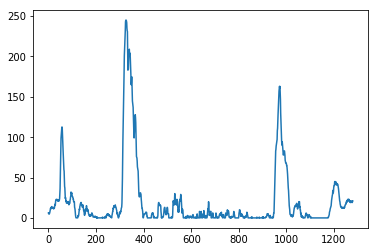

In [2]:
# Load our image
# `mpimg.imread` will load .jpg as 0-255, so normalize back to 0-1
img = mpimg.imread('warped_example.jpg')/255

def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
#     bottom_half = img[img.shape[0]//2:]
    bottom_half = img[img.shape[0]//2:,:]
#     print(bottom_half.shape)
#     print(type(img))
    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    print(histogram.shape)
    return histogram

# Create histogram of image binary activations
histogram = hist(img)

print(histogram)
# Visualize the resulting histogram
plt.plot(histogram)


#### Sliding Window
With this histogram we are adding up the pixel values along each column in the image. In our thresholded binary image, pixels are either 0 or 1, so the two most prominent peaks in this histogram will be good indicators of the x-position of the base of the lane lines. We can use that as a starting point for where to search for the lines. From that point, we can use a sliding window, placed around the line centers, to find and follow the lines up to the top of the frame.

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("./video/sliding_window.mp4"))

### 3.Finding the Lines: Sliding Window

#### Implement Sliding Windows and Fit a Polynomial(adj.多项式的;多词学名的n.多项式;多词学名)
![](./img/sliding_windows_and_fit_a_polynomial.png)

As shown in the previous animation, we can use the two highest peaks from our histogram as a starting point for determining where the lane lines are, and then use sliding windows moving upward in the image (further along the road) to determine where the lane lines go.

#### Split the histogram for the two lines
The first step we'll take is to split the histogram into two sides, one for each lane line.


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

>numpy.argmax(a, axis=None, out=None)
返回沿轴axis最大值的索引。

Note that in the above, we also create out_img to help with visualizing our output later on.

#### Set up windows and window hyperparameters
Our next step is to set a few hyperparameters related to our sliding windows, and set them up to iterate across the binary activations in the image. We have some base hyperparameters below, but don't forget to try out different values in your own implementation to see what works best!

In [ ]:
# HYPERPARAMETERS
# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50

# Set height of windows - based on nwindows above and image shape
window_height = np.int(binary_warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
nonzero = binary_warped.nonzero()#得到数组array中非零元素的位置(数组索引)
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated later for each window in nwindows
leftx_current = leftx_base
rightx_current = rightx_base

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []


In [14]:
a = np.array([[0,0,3],[0,1,0],[0,0,9]])
[0, 1, 2]

b1 = np.nonzero(a)
print(b1)
print("================")
a = np.array([[0,0,3],[0,0,0],[0,0,9],[0,6,0],[8,6,0]])
b2 = np.nonzero(a)
print(b2)
# [0, 2, 3, 4, 4]
# [2, 2, 1, 0, 1]
c = np.dstack((b2[0], b2[1]))
print(c.shape)
print(c)
c = c.reshape(c.shape[1], c.shape[2])
print("========c.reshpaed:")
print(c)
print("========np.squeeze()")
c = np.squeeze(c)
print(c)
print(c.shape)
print("================")
a1 = np.array([1,2,3])
c1 = np.dstack((a1, a1))
print(c1)

In [17]:
[0, 2, 3, 4, 4]
[2, 2, 1, 0, 1]
a = np.array([[0, 2, 3, 4, 4],
              [1, 1, 3, 4, 4],
              [4, 1, 3, 4, 4],
              [2, 2, 1, 0, 1],
              [3, 3, 1, 0, 1]])

# print(a)

b = a[np.where((a[:,0]>0)&(a[:,0]<4)&(a[:,1]>2))]
# print("========")
# print(b)

**Iterate through `nwindows` to track curvature**
Now that we've set up what the windows look like and have a starting point, we'll want to loop for `nwindows`, with the given window sliding left or right if it finds the mean position of activated pixels within the window to have shifted.

You'll implement this part in the quiz below, but here's a few steps to get you started:

1. Loop through each window in nwindows
2. Find the boundaries of our current window. This is based on a combination of the current window's starting point (leftx_current and rightx_current), as well as the margin you set in the hyperparameters.
3. Use `cv2.rectangle` to draw these window boundaries onto our visualization image out_img. This is required for the quiz, but you can skip this step in practice if you don't need to visualize where the windows are.
4. Now that we know the boundaries of our window, find out which activated pixels from nonzeroy and nonzerox above actually fall into the window.
5. Append these to our lists left_lane_inds and right_lane_inds.
6. If the number of pixels you found in Step 4 are greater than your hyperparameter `minpix`, re-center our window (i.e. `leftx_current` or `rightx_current`) based on the mean position of these pixels.

#### Fit a polynomial
Now that we have found all our pixels belonging to each line through the sliding window method, it's time to fit a polynomial to the line. First, we have a couple small steps to ready our pixels.

In [ ]:
# Concatenate the arrays of indices (previously was a list of lists of pixels)
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

>numpy.concatenate((a1,a2,...), axis=0)函数。能够一次完成多个数组的拼接。

We'll let you implement the function for the polynomial in the quiz below using `np.polyfit`.
> `np.polyfit`最小二乘法多项式拟合曲线

In [ ]:
# Assuming we have `left_fit` and `right_fit` from `np.polyfit` before
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

>numpy.linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None)
在指定的间隔内返回均匀间隔的数字。返回num均匀分布的样本，在[start, stop]。

Take note of how we fit the lines above - while normally you calculate a y-value for a given x, here we do the opposite. Why? Because we expect our lane lines to be (mostly) vertically-oriented.

#### Visualization
Once you reach this point, you're done! But here is how you can visualize the result as well:

In [ ]:
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

#### Quiz
In the below quiz, implement the following (see TO-DO's):

* Steps 2, 4 and 6 from above within the `for` loop in `find_lane_pixels()` - find the window boundaries, find all pixels within those boundaries, and if there are more than `minpix`, slide the window over to the mean of these pixels.
* Fit a polynomial to all the relevant pixels you've found in your sliding windows in `fit_polynomial()`.

In [2]:
left_lane_inds_global = []
right_lane_inds_global = []

========left_lane_inds1:
[82135 82136 82137 ... 14767 14768 14769]
========left_fitx:
[478.40459368 477.98844567 477.57282895 477.15774352 476.74318939
 476.32916654 475.91567499 475.50271473 475.09028577 474.67838809
 474.26702171 473.85618663 473.44588283 473.03611033 472.62686911
 472.2181592  471.80998057 471.40233324 470.99521719 470.58863244
 470.18257899 469.77705682 469.37206595 468.96760637 468.56367808
 468.16028109 467.75741539 467.35508098 466.95327786 466.55200604
 466.1512655  465.75105626 465.35137831 464.95223166 464.5536163
 464.15553223 463.75797945 463.36095796 462.96446777 462.56850887
 462.17308126 461.77818494 461.38381992 460.98998619 460.59668375
 460.2039126  459.81167275 459.41996419 459.02878692 458.63814094
 458.24802626 457.85844287 457.46939077 457.08086996 456.69288044
 456.30542222 455.91849529 455.53209965 455.14623531 454.76090226
 454.3761005  453.99183003 453.60809085 453.22488297 452.84220638
 452.46006108 452.07844708 451.69736436 451.31681294 450.

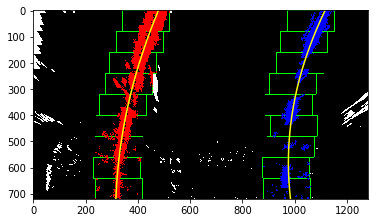

In [3]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

# Load our image
binary_warped = mpimg.imread('warped_example.jpg')

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 180
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

#     print("========nonzero:")
#     print(nonzero)
#     print(nonzeroy.shape)
#     print(nonzerox.shape)
#     print("========leftx_current:{}".format(leftx_current))
#     print("========rightx_current:{}".format(rightx_current))
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin//2  # Update this
        win_xleft_high = leftx_current + margin//2  # Update this
        win_xright_low = rightx_current - margin//2  # Update this
        win_xright_high = rightx_current + margin//2  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 

        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
#         print("========win_y_low:%d, win_y_high:%d,win_xleft_low:%d, win_xleft_high:%d}"
#               %(win_y_low,win_y_high,win_xleft_low,win_xleft_high))

        good_left_inds = (np.where((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)\
                          &(nonzerox >= win_xleft_low)&(nonzerox <= win_xleft_high)))[0]

        good_right_inds = (np.where((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)\
                          &(nonzerox >= win_xright_low)&(nonzerox <= win_xright_high)))[0]
            
#         good_left_inds = nonzerox[(nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)\
#                           &(nonzerox >= win_xleft_low)&(nonzerox <= win_xleft_high)]

#         good_right_inds = nonzerox[(nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)\
#                           &(nonzerox >= win_xright_low)&(nonzerox <= win_xright_high)]

#         print("========good_left_inds:")
#         print(good_left_inds)
#         print(type(good_left_inds))
#         print(good_left_inds.shape)
#         print("========good_right_inds:")
#         print(good_right_inds)
#         print(type(good_right_inds))
#         print(good_right_inds.shape)
#         print(type(left_lane_inds))

        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
#         print("========left_lane_inds0:")
#         print(left_lane_inds)
#         print(len(left_lane_inds))
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if(len(good_left_inds) > minpix ):
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
#             print("========leftx_current:{}".format(leftx_current))
            
        if(len(good_right_inds) > minpix):
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
#             print("========rightx_current:{}".format(rightx_current))
        
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
        global left_lane_inds_global
        left_lane_inds_global = left_lane_inds
        
        global right_lane_inds_global
        right_lane_inds_global = right_lane_inds
        
        print("========left_lane_inds1:")
        print(left_lane_inds)
#         print(len(left_lane_inds))
#         print(type(left_lane_inds))
#         print(left_lane_inds.shape)
        
#         print("========right_lane_inds1:")
#         print(right_lane_inds)
#         print(len(right_lane_inds))
#         print(type(right_lane_inds))
#         print(right_lane_inds.shape)
        
    except ValueError:
        # Avoids an error if the above is not implemented fully
        print("========Error")

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    #second order polynomial work
    left_fit = np.polyfit(lefty,leftx, 2)
    right_fit = np.polyfit(righty,rightx, 2)
    #third order polynomial work
#     left_fit = np.polyfit(lefty,leftx, 3)
#     right_fit = np.polyfit(righty,rightx, 3)

#     print("========leftx:")
#     print(leftx)
#     print("========lefty:")
#     print(lefty)
    
#     print("========rightx:")
#     print(rightx)
#     print("========righty:")
#     print(righty)
    
# 
    
#     print("========left_fit:")
#     print(left_fit)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
#     print("========ploty:")
#     print(ploty)
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        #third order polynomial work
#         left_fitx = left_fit[0]*ploty**3 + left_fit[1]*ploty**2 + left_fit[2]*ploty + left_fit[3]
#         right_fitx = right_fit[0]*ploty**3 + right_fit[1]*ploty**2 + right_fit[2]*ploty + right_fit[3]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        print("========Error")
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

#     plt.imshow(out_img)
    
    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    print("========left_fitx:")
    print(left_fitx)
    print("========right_fitx:")
    print(right_fitx)
    
#     print("out_img.shape:{}".format(out_img.shape))
    
    return out_img


out_img = fit_polynomial(binary_warped)

# mpimg.imsave("out_img.png", out_img)

plt.imshow(out_img)
plt.savefig('warped_example_output.png',dpi=400,bbox_inches='tight')

Result:
![](warped_example_output.png)

In [108]:
a = np.array([[1,4,7,8,6, 2, 5],
              [5,6,4,8,1,5,6],
              [5,6,4,8,1,5,6]])
# print(a)
# print(a.shape)
# print(a[0])
# indxs = np.where(a > 4)
# print("========indxs[0].len:{}".format(len(indxs[0])))
# print(indxs)
# print(type(indxs))
# print(np.where(a > 4))
# print(a[np.where(a > 4)])

In [128]:
a = np.array([[1, 2, 3, 4, 5],
              [1, 2, 3, 4, 5],
              [1, 2, 3, 4, 5]])
# print("========a:")
# print(a)
# b = np.sum(a)
# print("========b:")
# print(b)
# c = np.sum(a,axis=0)
# print("========c:")
# print(c)
# d = np.sum(a,axis=1)
# print("========d:")
# print(d)

多项式系数:
[-9.24538084e-04  3.76792011e-02 -5.54639386e-01  3.60545597e+00
  1.03629808e+00]
多项式方程:
            4           3          2
-0.0009245 x + 0.03768 x - 0.5546 x + 3.605 x + 1.036
调用，输入x值，得到y:
8.922135180995706


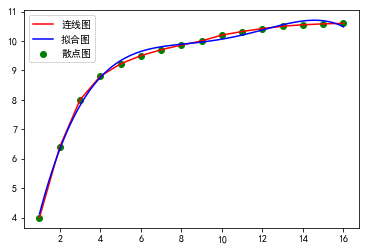

In [164]:
#多项式拟合(从给定的x,y中解析出最接近数据的方程式)
#要拟合的x,y数据
x = np.arange(1, 17, 1)
y = np.array([4.00, 6.40, 8.00, 8.80, 9.22, 9.50, 9.70, 9.86, 10.00, 10.20, 10.32, 10.42, 10.50, 10.55, 10.58, 10.60])
z1 = np.polyfit(x, y, 4)#3为多项式最高次幂，结果为多项式的各个系数
#最高次幂3，得到4个系数,从高次到低次排列
#最高次幂取几要视情况而定
p1 = np.poly1d(z1)#将系数代入方程，得到函式p1
print("多项式系数:")
print(z1)#多项式系数
print("多项式方程:")
print(p1)#多项式方程
print("调用，输入x值，得到y:")
print(p1(18))#调用，输入x值，得到y
x1=np.linspace(x.min(),x.max(),100)#x给定数据太少，方程曲线不光滑，多取x值得到光滑曲线
pp1=p1(x1)#x1代入多项式，得到pp1,代入matplotlib中画多项式曲线
plt.rcParams['font.sans-serif']=['SimHei']#显示中文
plt.scatter(x,y,color='g',label='散点图')#x，y散点图
plt.plot(x,y,color='r',label='连线图')#x,y线形图
plt.plot(x1,pp1,color='b',label='拟合图')#100个x及对应y值绘制的曲线
#可应用于各个行业的数值预估
plt.legend(loc='best')
plt.savefig('polyfit.png',dpi=400,bbox_inches='tight')

### 4.Finding the Lines: Search from Prior

#### Skip the sliding windows step once you've found the lines
![](./img/search_from_prior.png)
Great work! You've now built an algorithm that uses sliding windows to track the lane lines out into the distance. However, using the full algorithm from before and starting fresh on every frame may seem inefficient, as the lane lines don't necessarily move a lot from frame to frame.

In the next frame of video you don't need to do a blind search again, but instead you can just search in a margin around the previous lane line position, like in the above image. The green shaded area shows where we searched for the lines this time. So, once you know where the lines are in one frame of video, you can do a highly targeted search for them in the next frame.

This is equivalent to using a customized region of interest for each frame of video, and should help you track the lanes through sharp curves and tricky conditions. If you lose track of the lines, go back to your sliding windows search or other method to rediscover them.

Let's walk through one way to do this, and then you'll build it out further in a quiz below.

#### Use the previous polynomial to skip the sliding window
In the previous quiz, we used `left_lane_inds` and `right_lane_inds`to hold the pixel values contained within the boundaries of a given sliding window. This time, we'll take the polynomial functions we fit before (`left_fit` and `right_fit`), along with a hyperparameter `margin`, to determine which activated pixels fall into the green shaded areas from the above image. Note that this `margin` can be a different value than the one originally used for your sliding windows!

To implement this in the below quiz, you'll want to grab only those pixels with x-values that are +/- your `margin` from your polynomial lines. Note that you'll only need to implement `left_lane_inds` and `right_lane_inds` in the quiz - most of the surrounding code, ignoring iterating through the windows, is the same as before!

The way we'll visualize this is a bit different than last time around, however, so make sure to pay attention to that if you want to visualize this step while working on your project.

Quiz
In the below quiz, implement the following (see TO-DO's):

* Fit a polynomial to all the relevant pixels you've found in your sliding windows in `fit_poly()`.
* Set the area to search for activated pixels based on `margin` out from your fit polynomial within `search_around_poly`. Note that the quiz grader expects a `margin` of `100` pixels, but you can tune this as part of your own project!


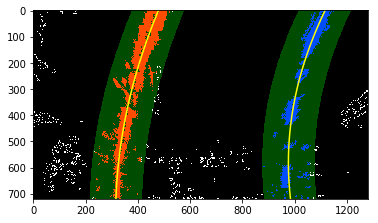

In [5]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Load our image - this should be a new frame since last time!
binary_warped = mpimg.imread('warped_example.jpg')

# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty,leftx, 2)
    right_fit = np.polyfit(righty,rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = left_lane_inds_global
    right_lane_inds = right_lane_inds_global

#     print("=======left_lane_inds:")
#     print(left_lane_inds)
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(binary_warped)

# View your output
plt.imshow(result)


#### Fitting on Large Curves
One thing to consider in our current implementation of sliding window search is what happens when we arrive at the left or right edge of an image, such as when there is a large curve on the road ahead. If `minpix` is not achieved (i.e. the curve ran off the image), the starting position of our next window doesn't change, so it is just positioned directly above the previous window. This will repeat for however many windows are left in `nwindows`, stacking the sliding windows vertically against the side of the image, and likely leading to an imperfect polynomial fit.

Can you think of a way to solve this issue? If you want to tackle the curves on the harder challenge video as part of the project, you might want to include this in your lane finding algorithm.

1. np.dstack
2. np.hstack
3. np.vstack
4. np.transpose
5. np.flipud


### 5.Measuring Curvature I
You're getting very close to a final result! You have a thresholded image, where you've estimated which pixels belong to the left and right lane lines (shown in red and blue, respectively, below), and you've fit a polynomial to those pixel positions. Next we'll compute the radius of curvature of the fit.

![](./img/color-fit-lines.jpg)

In the last exercise, you located the lane line pixels, used their x and y pixel positions to fit a second order polynomial curve:

${f(y) = Ay^2 + By + C}$

You're fitting for${f(y)}$, rather than ${f(x)}$, because the lane lines in the warped image are near vertical and may have the same ${x}$ value for more than one ${y}$ value.

Radius of Curvature
The radius of curvature ([awesome tutorial here](http://www.intmath.com/applications-differentiation/8-radius-curvature.php)) at any point ${x}$ of the function ${x = f(y)}$ is given as follows:

${\LARGE R_{curve} = \frac{[1 + (\frac{dx}{dy})^2]^{3/2}}{|\frac{d^2x}{dy^2}|}}$

In the case of the second order polynomial above, the first and second derivatives are:

${\large f'(y) = \frac{dx}{dy} = 2Ay + B}$

${\large f''(y) = \frac{d^2x}{dy^2} = 2A}$

So, our equation for radius of curvature becomes:

${\LARGE R_{curve} = \frac{(1 + (2Ay + B)^2)^{3/2}}{\left |2A \right |}}$

The ${y}$ values of your image increase from top to bottom, so if, for example, you wanted to measure the radius of curvature closest to your vehicle, you could evaluate the formula above at the ${y}$ value corresponding to the bottom of your image, or in Python, at `yvalue = image.shape[0]`.

#### Implementing the Calculation
#### Generate some fake data first
Most of the code below is just to generate some fake data to visualize with - everything up until the actual plotting of the data below should be replaced with your algorithms from before in your own implementation!


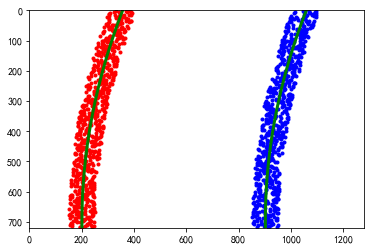

In [270]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

The output looks like this:
![](./img/measure_curvature_01.png)
Implementing the calculation itself
Now we have polynomial fits(多项式拟合) and we can calculate the radius of curvature(弯曲;曲度;曲率).

In the below quiz, you'll implement the radius of curvature calculation (using our fake generated data from above - remember that you'll be using your own implemented algorithm in place of the `generate_data` function in the below quiz!).

Use the ${\large R_{curve}}$ equation above in order to calculate `left_curverad` and `right_curverad` in the `measure_curvature_pixels()` function below.


In [6]:
#curve_pixels.py
import numpy as np

def generate_data():
    '''
    Generates fake data to use for calculating lane curvature.
    In your own project, you'll ignore this function and instead
    feed in the output of your lane detection algorithm to
    the lane curvature calculation.
    '''
    # Set random seed number so results are consistent for grader
    # Comment this out if you'd like to see results on different random data!
    np.random.seed(0)
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    right_fit = np.polyfit(ploty, rightx, 2)
    
    return ploty, left_fit, right_fit

    
def measure_curvature_pixels():
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit, right_fit = generate_data()
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    ## Implement the calculation of the left line here
    left_curverad = (1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**(3/2)/np.abs(2*left_fit[0])  
    
    ## Implement the calculation of the right line here
    right_curverad = (1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**(3/2)/np.abs(2*right_fit[0])  
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels()

print(left_curverad, right_curverad)
# Should see values of 1625.06 and 1976.30 here, if using
# the default `generate_data` function with given seed number

1625.0601831657232 1976.2967307714703


### 6.Measuring Curvature II
#### From Pixels to Real-World
Great! You've now calculated the radius of curvature for our lane lines. But now we need to stop and think... We've calculated the radius of curvature based on pixel values, so the radius we are reporting is in pixel space, which is not the same as real world space. So we actually need to repeat this calculation after converting our x and y values to real world space.

This involves measuring how long and wide the section of lane is that we're projecting in our warped image. We could do this in detail by measuring out the physical lane in the field of view of the camera, but for this project, you can assume that if you're projecting a section of lane similar to the images above, the lane is about 30 meters long and 3.7 meters wide. Or, if you prefer to derive a conversion from pixel space to world space in your own images, compare your images with U.S. regulations that require a minimum lane width of 12 feet or 3.7 meters, and the dashed lane lines are 10 feet or 3 meters long each.

Let's say that our camera image has 720 relevant pixels in the y-dimension (remember, our image is perspective-transformed!), and we'll say roughly 700 relevant pixels in the x-dimension (our example of fake generated data above used from 200 pixels on the left to 900 on the right, or 700). Therefore, to convert from pixels to real-world meter measurements, we can use:






In [ ]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

In the below quiz, you'll use the above conversions in order to adjust your calculation from before to give real-world lane curvature values. Once again, you'll focus on the `left_curverad` and `right_curverad` values within the new `measure_curvature_real()` function; however, you'll also need to adjust how you use `np.polyfit()` within `generate_data()` in order for this to work correctly. How do you need to change these to convert to meters?

In [13]:
import numpy as np

def generate_data(ym_per_pix, xm_per_pix):
    '''
    Generates fake data to use for calculating lane curvature.
    In your own project, you'll ignore this function and instead
    feed in the output of your lane detection algorithm to
    the lane curvature calculation.
    '''
    # Set random seed number so results are consistent for grader
    # Comment this out if you'd like to see results on different random data!
    np.random.seed(0)
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Fit a second order polynomial to pixel positions in each fake lane line
    ##### TO-DO: Fit new polynomials to x,y in world space #####
    ##### Utilize `ym_per_pix` & `xm_per_pix` here #####
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return ploty, left_fit_cr, right_fit_cr

    
def measure_curvature_real():
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    ## Implement the calculation of the left line here
    left_curverad = (1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**(3/2)/np.abs(2*left_fit_cr[0])  
    
    ## Implement the calculation of the right line here
    right_curverad = (1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**(3/2)/np.abs(2*right_fit_cr[0])  
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real()

print(left_curverad, 'm', right_curverad, 'm')
# Should see values of 533.75 and 648.16 here, if using
# the default `generate_data` function with given seed number



533.7525889210916 m 648.1574851434274 m


### 7.Additional Resources on Computer Vision

Additional Resources on Computer Vision
Nice work reaching the end of the computer vision content! While you still have the project left to do here, we're also providing some additional resources and recent research on the topic that you can come back to if you have time later on.

Reading research papers is a great way to get exposure(面临，遭受(危险或不快);揭露;(在电视、报纸等上的)亮相，被报道) to the latest and greatest in the field, as well as expand your learning. However, just like the project ahead, it's often best to learn by doing - if you find a paper that really excites you, try to implement it (or even something better) yourself!

#### Optional Reading
All of these are completely optional reading - you could spend hours reading through the entirety of these! We suggest moving onto the project first so you have what you’ve learned fresh on your mind, before coming back to check these out.

We've categorized these papers to hopefully help you narrow down which ones might be of interest, as well as highlighted a couple key reads by category by including their Abstract section, which summarizes the paper.

***

#### Lane Finding with Semantic Segmentation

The below papers and resources concern a technique called semantic segmentation, where each pixel of an image gets classified individually!

[Fully Convolutional Networks for Semantic Segmentation](https://arxiv.org/abs/1605.06211) by E. Shelhamer, J. Long and T. Darrell

>**Abstract:** Convolutional networks are powerful visual models that yield hierarchies of features. We show that convolutional networks by themselves, trained end-to-end, pixels-to-pixels, improve on the previous best result in semantic segmentation. Our key insight is to build "fully convolutional" networks that take input of arbitrary size and produce correspondingly-sized output with efficient inference and learning. We define and detail the space of fully convolutional networks, explain their application to spatially dense prediction tasks, and draw connections to prior models. We adapt contemporary classification networks (AlexNet, the VGG net, and GoogLeNet) into fully convolutional networks and transfer their learned representations by fine-tuning to the segmentation task. We then define a skip architecture that combines semantic information from a deep, coarse layer with appearance information from a shallow, fine layer to produce accurate and detailed segmentations. [...]

You can use the [KITTI road dataset](http://www.cvlibs.net/datasets/kitti/eval_road.php) with the above technique for a model that can detect open space on the road.

[Lane Detection with Deep Learning (Part 1)](https://towardsdatascience.com/lane-detection-with-deep-learning-part-1-9e096f3320b7) and [(Part 2)](https://towardsdatascience.com/lane-detection-with-deep-learning-part-2-3ba559b5c5af) by M. Virgo

>**Summary:** Udacity SDC student (and now Udacian!) investigates using a deep learning approach to lane detection in order to improve upon the Advanced Lane Finding project, eventually building a model with a fully convolutional neural network that detects the road is a wider variety of situations and at faster speed.

***

#### Other Lane Finding Techniques

The below paper uses a multi-task model to identify lane and road markings, as well as vanishing point of the road, in order to build a robust model.

[VPGNet: Vanishing Point Guided Network for Lane and Road Marking Detection and Recognition](https://arxiv.org/abs/1710.06288) by S. Lee, et. al.

>**Abstract:** In this paper, we propose a unified end-to-end trainable multi-task network that jointly handles lane and road marking detection and recognition that is guided by a vanishing point under adverse weather conditions. We tackle rainy and low illumination conditions [...] At night, color distortion occurs under limited illumination. As a result, no benchmark dataset exists and only a few developed algorithms work under poor weather conditions. To address this shortcoming, we build up a lane and road marking benchmark which consists of about 20,000 images with 17 lane and road marking classes under four different scenarios: no rain, rain, heavy rain, and night. We train and evaluate several versions of the proposed multi-task network and validate the importance of each task. The resulting approach, VPGNet, can detect and classify lanes and road markings, and predict a vanishing point with a single forward pass. Experimental results show that our approach achieves high accuracy and robustness under various conditions in real-time (20 fps). [...]

***

#### Vehicle Detection

The below paper builds a model to both detect vehicles as well as estimate their dimensions along the road.

[Learning to Map Vehicles into Bird's Eye View](https://arxiv.org/abs/1706.08442) by A. Palazzi, et. al.

>**Abstract:** Awareness of the road scene is an essential component for both autonomous vehicles and Advances Driver Assistance Systems and is gaining importance both for the academia and car companies. This paper presents a way to learn a semantic-aware transformation which maps detections from a dashboard camera view onto a broader bird's eye occupancy map of the scene. To this end, a huge synthetic dataset featuring 1M couples of frames, taken from both car dashboard and bird's eye view, has been collected and automatically annotated. A deep-network is then trained to warp detections from the first to the second view. We demonstrate the effectiveness of our model against several baselines and observe that is able to generalize on real-world data despite having been trained solely on synthetic ones.

***
You may have noticed a lot of the papers above include deep learning techniques, which are now commonly used in many computer vision applications. More on deep learning is coming up!



